In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization

from sklearn.model_selection import train_test_split

In [2]:
info = pd.read_csv("_info.csv")
info

,FileID,Negative,Typical,Atypical
0,0003b2210c64,0,1,0
1,00af6f8c2a3d,1,0,0
2,00c9033fbc2e,0,0,1
3,00e0ce73dac8,0,0,1
4,00f0a591f18a,0,1,0
...,...,...,...,...
1195,ff60a32aa049,0,0,1
1196,ff9666e69d19,0,1,0
1197,ff971972490d,1,0,0
1198,ffb804652089,1,0,0


In [3]:
y_OneHot = np.array(info[['Negative','Typical','Atypical']])
y_OneHot

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=int64)

In [14]:
fileids = info['FileID'].tolist()
X = []
for fileid in fileids:
    pixel_array = plt.imread("img/train_cut/{}.jpg".format(fileid))
    pixel_array = cv2.resize(pixel_array, (260,260))   # some size
    pixel_array = cv2.cvtColor(pixel_array, cv2.COLOR_GRAY2RGB)    # Gray2RBG
    X.append(pixel_array)
    
X = np.array(X)
X = X.astype("float16")
# 檢查
print(X.shape)

(1200, 260, 260, 3)


# 訓練集 測試集

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_OneHot, test_size=0.2)

In [17]:
def show_loss(_history):
    loss = _history.history['loss']
    val_loss = _history.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc="upper right")
    plt.show()
    
    # accuracy
    score = model.evaluate(X_test, y_test)
    print("test acc", score[1])
    

# EfficientNet Implementation :

In [18]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2

NUM_CLASSES = 3
IMG_SIZE = 260
size = (IMG_SIZE, IMG_SIZE)


inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# Using model without transfer learning

outputs = EfficientNetB2(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

In [8]:
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

model.summary()


with tf.device('/GPU:0'):
    hist = model.fit(X_train, 
                     y_train, 
                     batch_size=1,
                     validation_split=0.2,
                     epochs=30, 
                     verbose=2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 260, 260, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, 3)                7772796   
                                                                 
Total params: 7,772,796
Trainable params: 7,705,221
Non-trainable params: 67,575
_________________________________________________________________
Epoch 1/30
768/768 - 94s - loss: 1.8441 - accuracy: 0.3372 - val_loss: 5.3868 - val_accuracy: 0.2812 - 94s/epoch - 122ms/step
Epoch 2/30
768/768 - 80s - loss: 1.3001 - accuracy: 0.3516 - val_loss: 1.8774 - val_accuracy: 0.3229 - 80s/epoch - 105ms/step
Epoch 3/30
768/768 - 81s - loss: 1.2110 - accuracy: 0.3190 - val_loss: 1.2444 - val_accuracy: 0.3698 - 81s/epoch - 105ms/step
Epoch 4/30
768/768 - 82s - loss: 1.2099 - accuracy: 0.3294 - val

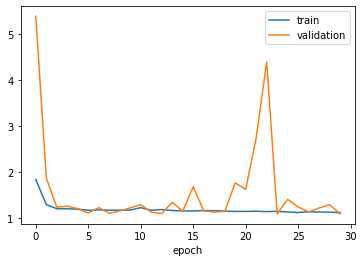

8/8 [==============================] - 7s 436ms/step - loss: 1.1035 - accuracy: 0.3583
test acc 0.3583333194255829


In [9]:
show_loss(hist)

In [10]:
model.save("model/ef_20211116.md")

INFO:tensorflow:Assets written to: model/ef_20211116.md\assets


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\ProgramData\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# 嘗試遷移學習

In [ ]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
import tensorflow as tf

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os


NUM_CLASSES = 3
IMG_SIZE = 224